In [20]:
import os
import gc
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation, record_evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# Read the Data

In [21]:
working_directory = os.getcwd()
print(working_directory)
data = pd.read_csv(f"{working_directory}/Input_Data/creditcard_post_correlation.csv") #Change the path to your dataset, if needed

c:\Users\teovr\Desktop\Projects\Predicting_Fraudulent_Transactions_With_Machine_Learning


## Define Predictors and Target Variables
##### We will specify the predictor features and the target variable. Additionally, categorical features can be identified if present. In this case, there are no categorical features.



In [22]:
# Define the target variable
target = 'Fraud_Flag'

# Define the features to be used in the model
predictors = [
    'Transaction_Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
    'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
    'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',
    'Transaction_Amount'
]

## Define the TRAIN/VALIDATION/TEST SPLIT

In [23]:
#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation

RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop 
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

# Set the path to the input data
IS_LOCAL = True  # Set to True since you we running locally

if IS_LOCAL:
    PATH = (f"{working_directory}/Input_Data/")
else:
    PATH = "../input"

print(os.listdir(PATH))  # List the files in the specified directory

['creditcard.csv', 'creditcard_cleaned.csv', 'creditcard_post_correlation.csv', 'creditcard_post_exploration.csv', 'download_data_link.txt']


## Split data in train, test and validation set

In [24]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(
    data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

# Further split the training set into training and validation sets
train_df, valid_df = train_test_split(
    train_df, 
    test_size=VALID_SIZE, 
    random_state=RANDOM_STATE, 
    shuffle=True
)

## Training and validation using cross-validation

##### Let's apply cross-validation. We will use 5-fold cross-validation (KFold), where the data is split into 5 folds. In each iteration, the model is trained on 4 folds and validated on the remaining fold.

The final test set performance is computed as the average of the predictions across all folds.

In [25]:
# Initialize KFold
kf = KFold(n_splits=NUMBER_KFOLDS, random_state=RANDOM_STATE, shuffle=True)

# Define evaluation results dictionary
evals_results = {}

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()
n_fold = 0

# K-Fold training loop
for train_idx, valid_idx in kf.split(train_df):
    train_x, train_y = train_df[predictors].iloc[train_idx], train_df[target].iloc[train_idx]
    valid_x, valid_y = train_df[predictors].iloc[valid_idx], train_df[target].iloc[valid_idx]
    
    evals_results = {}

    model = LGBMClassifier(
        nthread=-1,
        n_estimators=2000,
        learning_rate=0.01,
        num_leaves=80,
        colsample_bytree=0.98,
        subsample=0.78,
        reg_alpha=0.04,
        reg_lambda=0.073,
        subsample_for_bin=50,
        boosting_type='gbdt',
        is_unbalance=False,
        min_split_gain=0.025,
        min_child_weight=40,
        min_child_samples=510,
        objective='binary'
    )

    model.fit(
    train_x, train_y,
    eval_set=[(train_x, train_y), (valid_x, valid_y)],
    eval_metric='auc',
    callbacks=[
        early_stopping(EARLY_STOP),
        log_evaluation(VERBOSE_EVAL),
        record_evaluation(evals_results)
    ]
)
    # Predict on validation and test set
    oof_preds[valid_idx] = model.predict_proba(valid_x, num_iteration=model.best_iteration_)[:, 1]
    test_preds += model.predict_proba(test_df[predictors], num_iteration=model.best_iteration_)[:, 1] / kf.n_splits

    # Record feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = predictors
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # Print fold AUC
    print(f'Fold {n_fold + 1} AUC : {roc_auc_score(valid_y, oof_preds[valid_idx]):.6f}')

    # Clean up
    del model, train_x, train_y, valid_x, valid_y
    gc.collect()
    n_fold += 1

# Full validation score
train_auc_score = roc_auc_score(train_df[target], oof_preds)
print(f'Full AUC score {train_auc_score:.6f}')

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Number of positive: 233, number of negative: 145587
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007626 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 145820, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001598 -> initscore=-6.437491
[LightGBM] [Info] Start training from score -6.437491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [26]:
predictions6 = test_preds

### Success Metrics

- **Accuracy**: The proportion of total predictions that were correct.
- **Precision**: The proportion of positive identifications that were actually correct (minimizes false positives).
- **Recall (Sensitivity)**: The proportion of actual positives that were correctly identified (minimizes false negatives).
- **F1 Score**: The harmonic mean of precision and recall, providing a balance between the two.
- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall classification performance, especially important for imbalanced datasets.
- **Classification Report**: A detailed summary including precision, recall, F1-score, and support for each class.

These metrics provide a more comprehensive view of model performance, especially for imbalanced datasets like fraud detection.

In [27]:
# Calculate and print evaluation metrics for cross-validated LightGBM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def print_metrics(y_true, y_pred, dataset_name):
    print(f"--- {dataset_name} Metrics ---")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred):.4f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Not Fraud", "Fraud"]))
    print("\n")

# Convert probabilities to class labels using 0.5 threshold
train_pred_cv = (oof_preds >= 0.5).astype(int)
test_pred_cv = (predictions6 >= 0.5).astype(int)

# Print metrics for train and test sets
print_metrics(train_df[target].values, train_pred_cv, "Train (CV)")
print_metrics(test_df[target].values, test_pred_cv, "Test")

--- Train (CV) Metrics ---
Accuracy: 0.9984
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC-AUC Score: 0.5000

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00    181986
       Fraud       0.00      0.00      0.00       290

    accuracy                           1.00    182276
   macro avg       0.50      0.50      0.50    182276
weighted avg       1.00      1.00      1.00    182276



--- Test Metrics ---
Accuracy: 0.9982
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC-AUC Score: 0.5000

Classification Report:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56862
       Fraud       0.00      0.00      0.00       100

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962





C:\Users\teovr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\teovr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\teovr\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

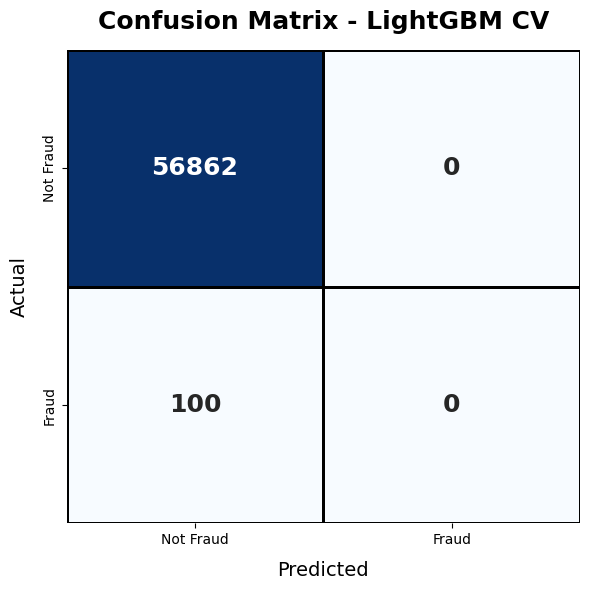

In [28]:
# Plot confusion matrix for cross-validated predictions (LightGBM CV)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm_cv = confusion_matrix(test_df[target].values, test_pred_cv)
plt.figure(figsize=(6, 6))
sns.heatmap(
    cm_cv,
    annot=True,
    fmt='d',
    cmap="Blues",
    linewidths=1,
    linecolor="black",
    cbar=False,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot_kws={"size": 18, "weight": "bold"}
)
plt.title('Confusion Matrix - LightGBM CV', fontsize=18, fontweight='bold', pad=15)
plt.xlabel('Predicted', fontsize=14, labelpad=10)
plt.ylabel('Actual', fontsize=14, labelpad=10)
plt.tight_layout()
plt.show()

### Explanation of Evaluation Metrics

The following metrics are used to evaluate the performance of the LightGBM classifier with cross-validation on the fraud detection task:

- **Accuracy**: The proportion of total predictions that were correct. In imbalanced datasets, accuracy can be misleading, as a model can achieve high accuracy by simply predicting the majority class.

- **Precision**: The proportion of positive predictions (fraud) that were actually correct. High precision means that when the model predicts fraud, it is usually correct. Important when the cost of a false positive is high.

- **Recall (Sensitivity)**: The proportion of actual fraud cases that were correctly identified. High recall means the model detects most frauds. Important when missing a fraud case is costly.

- **F1 Score**: The harmonic mean of precision and recall. It balances the trade-off between precision and recall, especially useful for imbalanced datasets.

- **ROC-AUC Score**: Measures the model's ability to distinguish between classes across all thresholds. A higher ROC-AUC indicates better overall performance.

- **Classification Report**: Provides a detailed breakdown of precision, recall, F1-score, and support for each class (fraud and not fraud).

**Note:** In fraud detection, recall and ROC-AUC are often prioritized, as it is crucial to identify as many fraudulent transactions as possible, even if it means accepting some false positives.